In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, \
         0.21, 0.22, 0.23, 0.24, 0.25, 0.25, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
i_beta_21_04 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 100    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.4
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 1))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_21_04[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 80.27287793159485 
    loop_MC 1 - time has passed: 158.24156093597412 
    loop_MC 2 - time has passed: 237.11845207214355 
    loop_MC 3 - time has passed: 315.0780415534973 
    loop_MC 4 - time has passed: 394.00337433815 
    loop_MC 5 - time has passed: 472.04437375068665 
    loop_MC 6 - time has passed: 528.3009717464447 
    loop_MC 7 - time has passed: 606.5821678638458 
    loop_MC 8 - time has passed: 684.5536377429962 
    loop_MC 9 - time has passed: 761.2437381744385 
    loop_MC 10 - time has passed: 839.1524605751038 
    loop_MC 11 - time has passed: 918.1281523704529 
    loop_MC 12 - time has passed: 974.8767049312592 
    loop_MC 13 - time has passed: 1052.6761510372162 
    loop_MC 14 - time has passed: 1130.5382039546967 
    loop_MC 15 - time has passed: 1207.7931823730469 
    loop_MC 16 - time has passed: 1286.8102006912231 
    loop_MC 17 - time has passed: 1365.2616991996765 
    loop_MC 18 - time has passed: 1442.36975932121

    loop_MC 54 - time has passed: 4141.417973995209 
    loop_MC 55 - time has passed: 4196.869700193405 
    loop_MC 56 - time has passed: 4276.361082315445 
    loop_MC 57 - time has passed: 4354.803251981735 
    loop_MC 58 - time has passed: 4430.122105121613 
    loop_MC 59 - time has passed: 4508.9906713962555 
    loop_MC 60 - time has passed: 4586.552294969559 
    loop_MC 61 - time has passed: 4663.881203889847 
    loop_MC 62 - time has passed: 4743.02307844162 
    loop_MC 63 - time has passed: 4819.7812378406525 
    loop_MC 64 - time has passed: 4896.49263048172 
    loop_MC 65 - time has passed: 4974.650612354279 
    loop_MC 66 - time has passed: 5051.959857463837 
    loop_MC 67 - time has passed: 5129.047298908234 
    loop_MC 68 - time has passed: 5184.752166509628 
    loop_MC 69 - time has passed: 5260.289300918579 
    loop_MC 70 - time has passed: 5336.060310602188 
    loop_MC 71 - time has passed: 5412.332765340805 
    loop_MC 72 - time has passed: 5468.2901201

    loop_MC 7 - time has passed: 593.9696581363678 
    loop_MC 8 - time has passed: 671.9165449142456 
    loop_MC 9 - time has passed: 750.3697047233582 
    loop_MC 10 - time has passed: 828.9607379436493 
    loop_MC 11 - time has passed: 905.9636127948761 
    loop_MC 12 - time has passed: 983.6381604671478 
    loop_MC 13 - time has passed: 1061.9562935829163 
    loop_MC 14 - time has passed: 1138.2273561954498 
    loop_MC 15 - time has passed: 1214.7832403182983 
    loop_MC 16 - time has passed: 1293.1088705062866 
    loop_MC 17 - time has passed: 1370.6731584072113 
    loop_MC 18 - time has passed: 1448.9175395965576 
    loop_MC 19 - time has passed: 1525.853567123413 
    loop_MC 20 - time has passed: 1602.8115012645721 
    loop_MC 21 - time has passed: 1679.9698696136475 
    loop_MC 22 - time has passed: 1756.5179080963135 
    loop_MC 23 - time has passed: 1834.7313590049744 
    loop_MC 24 - time has passed: 1912.8948864936829 
    loop_MC 25 - time has passed: 1990

    loop_MC 61 - time has passed: 4668.460366487503 
    loop_MC 62 - time has passed: 4724.969824790955 
    loop_MC 63 - time has passed: 4803.477702140808 
    loop_MC 64 - time has passed: 4881.792016506195 
    loop_MC 65 - time has passed: 4960.345114946365 
    loop_MC 66 - time has passed: 5038.475713253021 
    loop_MC 67 - time has passed: 5116.298621892929 
    loop_MC 68 - time has passed: 5192.328433275223 
    loop_MC 69 - time has passed: 5247.570297956467 
    loop_MC 70 - time has passed: 5325.94452214241 
    loop_MC 71 - time has passed: 5402.9932453632355 
    loop_MC 72 - time has passed: 5479.922482728958 
    loop_MC 73 - time has passed: 5556.533125400543 
    loop_MC 74 - time has passed: 5631.0281455516815 
    loop_MC 75 - time has passed: 5709.225539684296 
    loop_MC 76 - time has passed: 5788.110805034637 
    loop_MC 77 - time has passed: 5865.075114488602 
    loop_MC 78 - time has passed: 5939.905489683151 
    loop_MC 79 - time has passed: 6018.260275

    loop_MC 14 - time has passed: 1128.3707058429718 
    loop_MC 15 - time has passed: 1207.0773177146912 
    loop_MC 16 - time has passed: 1284.0109174251556 
    loop_MC 17 - time has passed: 1359.875774383545 
    loop_MC 18 - time has passed: 1435.8461940288544 
    loop_MC 19 - time has passed: 1513.9673080444336 
    loop_MC 20 - time has passed: 1593.1183257102966 
    loop_MC 21 - time has passed: 1671.8809967041016 
    loop_MC 22 - time has passed: 1750.649446964264 
    loop_MC 23 - time has passed: 1828.297189950943 
    loop_MC 24 - time has passed: 1906.818370103836 
    loop_MC 25 - time has passed: 1985.2936129570007 
    loop_MC 26 - time has passed: 2063.2396330833435 
    loop_MC 27 - time has passed: 2120.4189693927765 
    loop_MC 28 - time has passed: 2198.8283224105835 
    loop_MC 29 - time has passed: 2276.9463109970093 
    loop_MC 30 - time has passed: 2354.8606243133545 
    loop_MC 31 - time has passed: 2433.8757202625275 
    loop_MC 32 - time has passed

    loop_MC 68 - time has passed: 5245.830758571625 
    loop_MC 69 - time has passed: 5323.267847776413 
    loop_MC 70 - time has passed: 5403.017716407776 
    loop_MC 71 - time has passed: 5481.594345569611 
    loop_MC 72 - time has passed: 5558.737138271332 
    loop_MC 73 - time has passed: 5637.2319712638855 
    loop_MC 74 - time has passed: 5717.3783259391785 
    loop_MC 75 - time has passed: 5795.419690847397 
    loop_MC 76 - time has passed: 5873.034706115723 
    loop_MC 77 - time has passed: 5951.781241416931 
    loop_MC 78 - time has passed: 6029.034267663956 
    loop_MC 79 - time has passed: 6104.725300788879 
    loop_MC 80 - time has passed: 6181.415045261383 
    loop_MC 81 - time has passed: 6259.328275203705 
    loop_MC 82 - time has passed: 6336.642730712891 
    loop_MC 83 - time has passed: 6413.692211866379 
    loop_MC 84 - time has passed: 6490.967237949371 
    loop_MC 85 - time has passed: 6568.310685873032 
    loop_MC 86 - time has passed: 6644.89760

    loop_MC 21 - time has passed: 1683.2001616954803 
    loop_MC 22 - time has passed: 1760.390569448471 
    loop_MC 23 - time has passed: 1836.4568650722504 
    loop_MC 24 - time has passed: 1915.0385057926178 
    loop_MC 25 - time has passed: 1991.9527356624603 
    loop_MC 26 - time has passed: 2047.8822569847107 
    loop_MC 27 - time has passed: 2126.8319506645203 
    loop_MC 28 - time has passed: 2202.913334608078 
    loop_MC 29 - time has passed: 2279.789051771164 
    loop_MC 30 - time has passed: 2358.149522781372 
    loop_MC 31 - time has passed: 2436.3425738811493 
    loop_MC 32 - time has passed: 2513.420379638672 
    loop_MC 33 - time has passed: 2590.6444098949432 
    loop_MC 34 - time has passed: 2667.7665786743164 
    loop_MC 35 - time has passed: 2746.065892457962 
    loop_MC 36 - time has passed: 2823.9164888858795 
    loop_MC 37 - time has passed: 2900.572730779648 
    loop_MC 38 - time has passed: 2977.2498078346252 
    loop_MC 39 - time has passed: 3

    loop_MC 74 - time has passed: 5668.58588051796 
    loop_MC 75 - time has passed: 5746.640146970749 
    loop_MC 76 - time has passed: 5802.0491580963135 
    loop_MC 77 - time has passed: 5879.50076174736 
    loop_MC 78 - time has passed: 5958.210155010223 
    loop_MC 79 - time has passed: 6035.786972999573 
    loop_MC 80 - time has passed: 6114.302628040314 
    loop_MC 81 - time has passed: 6192.098094940186 
    loop_MC 82 - time has passed: 6270.752938747406 
    loop_MC 83 - time has passed: 6346.658752441406 
    loop_MC 84 - time has passed: 6424.198255300522 
    loop_MC 85 - time has passed: 6501.896661043167 
    loop_MC 86 - time has passed: 6579.822216749191 
    loop_MC 87 - time has passed: 6656.659155130386 
    loop_MC 88 - time has passed: 6733.76735830307 
    loop_MC 89 - time has passed: 6810.962500810623 
    loop_MC 90 - time has passed: 6888.457663536072 
    loop_MC 91 - time has passed: 6967.111948251724 
    loop_MC 92 - time has passed: 7044.726661443

    loop_MC 27 - time has passed: 2121.791789293289 
    loop_MC 28 - time has passed: 2177.765620946884 
    loop_MC 29 - time has passed: 2256.5310809612274 
    loop_MC 30 - time has passed: 2333.639233112335 
    loop_MC 31 - time has passed: 2410.2223863601685 
    loop_MC 32 - time has passed: 2466.156951189041 
    loop_MC 33 - time has passed: 2544.3093457221985 
    loop_MC 34 - time has passed: 2623.0300340652466 
    loop_MC 35 - time has passed: 2700.044321537018 
    loop_MC 36 - time has passed: 2777.945864200592 
    loop_MC 37 - time has passed: 2855.481783390045 
    loop_MC 38 - time has passed: 2933.5177903175354 
    loop_MC 39 - time has passed: 3009.856994867325 
    loop_MC 40 - time has passed: 3086.481986761093 
    loop_MC 41 - time has passed: 3164.3213951587677 
    loop_MC 42 - time has passed: 3241.778424501419 
    loop_MC 43 - time has passed: 3321.1292819976807 
    loop_MC 44 - time has passed: 3399.6911437511444 
    loop_MC 45 - time has passed: 3477

    loop_MC 81 - time has passed: 6217.513841152191 
    loop_MC 82 - time has passed: 6295.23361158371 
    loop_MC 83 - time has passed: 6372.101803064346 
    loop_MC 84 - time has passed: 6450.061853647232 
    loop_MC 85 - time has passed: 6527.90157699585 
    loop_MC 86 - time has passed: 6605.392887592316 
    loop_MC 87 - time has passed: 6680.512757539749 
    loop_MC 88 - time has passed: 6759.340051651001 
    loop_MC 89 - time has passed: 6837.120879650116 
    loop_MC 90 - time has passed: 6915.698307514191 
    loop_MC 91 - time has passed: 6971.602625131607 
    loop_MC 92 - time has passed: 7050.133426427841 
    loop_MC 93 - time has passed: 7127.464526891708 
    loop_MC 94 - time has passed: 7206.126115560532 
    loop_MC 95 - time has passed: 7284.26082110405 
    loop_MC 96 - time has passed: 7361.568323135376 
    loop_MC 97 - time has passed: 7437.777064323425 
    loop_MC 98 - time has passed: 7513.390415668488 
    loop_MC 99 - time has passed: 7591.5623402595

    loop_MC 34 - time has passed: 2686.673994064331 
    loop_MC 35 - time has passed: 2762.1217296123505 
    loop_MC 36 - time has passed: 2837.8596861362457 
    loop_MC 37 - time has passed: 2913.7466270923615 
    loop_MC 38 - time has passed: 2991.2563202381134 
    loop_MC 39 - time has passed: 3066.5575561523438 
    loop_MC 40 - time has passed: 3141.4595289230347 
    loop_MC 41 - time has passed: 3218.292295217514 
    loop_MC 42 - time has passed: 3295.2321581840515 
    loop_MC 43 - time has passed: 3373.3706216812134 
    loop_MC 44 - time has passed: 3451.155983686447 
    loop_MC 45 - time has passed: 3527.415632009506 
    loop_MC 46 - time has passed: 3604.39865398407 
    loop_MC 47 - time has passed: 3681.472811937332 
    loop_MC 48 - time has passed: 3759.213359594345 
    loop_MC 49 - time has passed: 3814.416584253311 
    loop_MC 50 - time has passed: 3891.1851136684418 
    loop_MC 51 - time has passed: 3968.458284854889 
    loop_MC 52 - time has passed: 4046

    loop_MC 88 - time has passed: 6795.838367938995 
    loop_MC 89 - time has passed: 6872.620115995407 
    loop_MC 90 - time has passed: 6947.998902797699 
    loop_MC 91 - time has passed: 7025.951987504959 
    loop_MC 92 - time has passed: 7101.199349164963 
    loop_MC 93 - time has passed: 7157.154249429703 
    loop_MC 94 - time has passed: 7234.726372241974 
    loop_MC 95 - time has passed: 7289.695966005325 
    loop_MC 96 - time has passed: 7366.026707410812 
    loop_MC 97 - time has passed: 7443.191793203354 
    loop_MC 98 - time has passed: 7520.6040279865265 
    loop_MC 99 - time has passed: 7599.076633930206 
loop_b 16 - time has passed: 128470.23299360275 
    loop_MC 0 - time has passed: 73.3559639453888 
    loop_MC 1 - time has passed: 146.49807024002075 
    loop_MC 2 - time has passed: 222.43788051605225 
    loop_MC 3 - time has passed: 277.9771752357483 
    loop_MC 4 - time has passed: 350.8237814903259 
    loop_MC 5 - time has passed: 425.3439795970917 
 

    loop_MC 41 - time has passed: 3071.4151599407196 
    loop_MC 42 - time has passed: 3126.981760263443 
    loop_MC 43 - time has passed: 3200.3789999485016 
    loop_MC 44 - time has passed: 3277.660225391388 
    loop_MC 45 - time has passed: 3350.094653367996 
    loop_MC 46 - time has passed: 3421.812762260437 
    loop_MC 47 - time has passed: 3496.0233993530273 
    loop_MC 48 - time has passed: 3569.390780687332 
    loop_MC 49 - time has passed: 3646.4664874076843 
    loop_MC 50 - time has passed: 3719.9663021564484 
    loop_MC 51 - time has passed: 3794.8947608470917 
    loop_MC 52 - time has passed: 3867.704650402069 
    loop_MC 53 - time has passed: 3939.118389606476 
    loop_MC 54 - time has passed: 4012.260271549225 
    loop_MC 55 - time has passed: 4085.4037601947784 
    loop_MC 56 - time has passed: 4158.357353448868 
    loop_MC 57 - time has passed: 4236.73504281044 
    loop_MC 58 - time has passed: 4309.031490564346 
    loop_MC 59 - time has passed: 4382.0

    loop_MC 95 - time has passed: 6890.581217765808 
    loop_MC 96 - time has passed: 6968.701213359833 
    loop_MC 97 - time has passed: 7040.546046733856 
    loop_MC 98 - time has passed: 7116.889385700226 
    loop_MC 99 - time has passed: 7194.832040309906 
loop_b 19 - time has passed: 150419.22188472748 
    loop_MC 0 - time has passed: 70.11977767944336 
    loop_MC 1 - time has passed: 125.75978803634644 
    loop_MC 2 - time has passed: 195.57734155654907 
    loop_MC 3 - time has passed: 267.7690804004669 
    loop_MC 4 - time has passed: 337.56985902786255 
    loop_MC 5 - time has passed: 415.3844528198242 
    loop_MC 6 - time has passed: 492.7754864692688 
    loop_MC 7 - time has passed: 562.9438989162445 
    loop_MC 8 - time has passed: 633.4741997718811 
    loop_MC 9 - time has passed: 705.0877907276154 
    loop_MC 10 - time has passed: 776.1817800998688 
    loop_MC 11 - time has passed: 847.4277768135071 
    loop_MC 12 - time has passed: 917.6185808181763 
    

    loop_MC 48 - time has passed: 3478.7771599292755 
    loop_MC 49 - time has passed: 3536.9809758663177 
    loop_MC 50 - time has passed: 3612.027106523514 
    loop_MC 51 - time has passed: 3687.845776319504 
    loop_MC 52 - time has passed: 3757.605236053467 
    loop_MC 53 - time has passed: 3828.2056584358215 
    loop_MC 54 - time has passed: 3900.043445587158 
    loop_MC 55 - time has passed: 3977.8227298259735 
    loop_MC 56 - time has passed: 4048.732699394226 
    loop_MC 57 - time has passed: 4118.612624168396 
    loop_MC 58 - time has passed: 4174.4780259132385 
    loop_MC 59 - time has passed: 4243.751586437225 
    loop_MC 60 - time has passed: 4313.729989290237 
    loop_MC 61 - time has passed: 4384.1052894592285 
    loop_MC 62 - time has passed: 4455.058980464935 
    loop_MC 63 - time has passed: 4524.829216957092 
    loop_MC 64 - time has passed: 4593.385437965393 
    loop_MC 65 - time has passed: 4664.135869264603 
    loop_MC 66 - time has passed: 4733.6

    loop_MC 1 - time has passed: 135.91006207466125 
    loop_MC 2 - time has passed: 213.38995170593262 
    loop_MC 3 - time has passed: 280.7653591632843 
    loop_MC 4 - time has passed: 348.1404278278351 
    loop_MC 5 - time has passed: 415.8261225223541 
    loop_MC 6 - time has passed: 483.5602900981903 
    loop_MC 7 - time has passed: 560.3525874614716 
    loop_MC 8 - time has passed: 627.3903071880341 
    loop_MC 9 - time has passed: 704.6849012374878 
    loop_MC 10 - time has passed: 772.7164862155914 
    loop_MC 11 - time has passed: 841.4528002738953 
    loop_MC 12 - time has passed: 909.6714334487915 
    loop_MC 13 - time has passed: 986.9254372119904 
    loop_MC 14 - time has passed: 1053.529192686081 
    loop_MC 15 - time has passed: 1132.3659312725067 
    loop_MC 16 - time has passed: 1199.4248669147491 
    loop_MC 17 - time has passed: 1276.4153430461884 
    loop_MC 18 - time has passed: 1344.8261625766754 
    loop_MC 19 - time has passed: 1412.7270925045

    loop_MC 55 - time has passed: 3793.9961438179016 
    loop_MC 56 - time has passed: 3860.909534215927 
    loop_MC 57 - time has passed: 3927.9961926937103 
    loop_MC 58 - time has passed: 3995.404967069626 
    loop_MC 59 - time has passed: 4066.103693962097 
    loop_MC 60 - time has passed: 4133.058127164841 
    loop_MC 61 - time has passed: 4200.017023324966 
    loop_MC 62 - time has passed: 4266.9606721401215 
    loop_MC 63 - time has passed: 4344.806464672089 
    loop_MC 64 - time has passed: 4411.6678993701935 
    loop_MC 65 - time has passed: 4478.82445025444 
    loop_MC 66 - time has passed: 4546.4680280685425 
    loop_MC 67 - time has passed: 4614.051525354385 
    loop_MC 68 - time has passed: 4680.27111697197 
    loop_MC 69 - time has passed: 4747.015808343887 
    loop_MC 70 - time has passed: 4813.858783483505 
    loop_MC 71 - time has passed: 4894.775204181671 
    loop_MC 72 - time has passed: 4962.228638648987 
    loop_MC 73 - time has passed: 5029.0870

    loop_MC 8 - time has passed: 586.9251470565796 
    loop_MC 9 - time has passed: 650.8283574581146 
    loop_MC 10 - time has passed: 716.1933786869049 
    loop_MC 11 - time has passed: 781.3360815048218 
    loop_MC 12 - time has passed: 848.570220708847 
    loop_MC 13 - time has passed: 913.7199676036835 
    loop_MC 14 - time has passed: 979.0144927501678 
    loop_MC 15 - time has passed: 1043.3803822994232 
    loop_MC 16 - time has passed: 1108.2735533714294 
    loop_MC 17 - time has passed: 1185.3961567878723 
    loop_MC 18 - time has passed: 1250.529592037201 
    loop_MC 19 - time has passed: 1314.2331893444061 
    loop_MC 20 - time has passed: 1378.5941746234894 
    loop_MC 21 - time has passed: 1443.2288057804108 
    loop_MC 22 - time has passed: 1509.4456646442413 
    loop_MC 23 - time has passed: 1564.7496175765991 
    loop_MC 24 - time has passed: 1642.3767075538635 
    loop_MC 25 - time has passed: 1719.8809974193573 
    loop_MC 26 - time has passed: 1785.

    loop_MC 61 - time has passed: 4018.5544724464417 
    loop_MC 62 - time has passed: 4083.0429813861847 
    loop_MC 63 - time has passed: 4148.483512639999 
    loop_MC 64 - time has passed: 4211.945230007172 
    loop_MC 65 - time has passed: 4276.106865167618 
    loop_MC 66 - time has passed: 4340.3056852817535 
    loop_MC 67 - time has passed: 4404.769307136536 
    loop_MC 68 - time has passed: 4469.963316440582 
    loop_MC 69 - time has passed: 4535.085422992706 
    loop_MC 70 - time has passed: 4598.834147453308 
    loop_MC 71 - time has passed: 4676.110839605331 
    loop_MC 72 - time has passed: 4740.565173625946 
    loop_MC 73 - time has passed: 4804.939301252365 
    loop_MC 74 - time has passed: 4868.439586162567 
    loop_MC 75 - time has passed: 4944.652548789978 
    loop_MC 76 - time has passed: 5008.996810674667 
    loop_MC 77 - time has passed: 5073.830146551132 
    loop_MC 78 - time has passed: 5138.237108945847 
    loop_MC 79 - time has passed: 5202.7624

    loop_MC 14 - time has passed: 946.6115024089813 
    loop_MC 15 - time has passed: 1009.3692977428436 
    loop_MC 16 - time has passed: 1072.0329039096832 
    loop_MC 17 - time has passed: 1135.2232720851898 
    loop_MC 18 - time has passed: 1197.5364212989807 
    loop_MC 19 - time has passed: 1260.5772047042847 
    loop_MC 20 - time has passed: 1323.5536952018738 
    loop_MC 21 - time has passed: 1386.208508491516 
    loop_MC 22 - time has passed: 1448.4991936683655 
    loop_MC 23 - time has passed: 1525.0787408351898 
    loop_MC 24 - time has passed: 1587.6146399974823 
    loop_MC 25 - time has passed: 1665.522879600525 
    loop_MC 26 - time has passed: 1727.4999516010284 
    loop_MC 27 - time has passed: 1790.905390739441 
    loop_MC 28 - time has passed: 1853.723403930664 
    loop_MC 29 - time has passed: 1915.798033952713 
    loop_MC 30 - time has passed: 1977.532330751419 
    loop_MC 31 - time has passed: 2040.2470335960388 
    loop_MC 32 - time has passed: 2

    loop_MC 67 - time has passed: 3968.121250629425 
    loop_MC 68 - time has passed: 4007.855180978775 
    loop_MC 69 - time has passed: 4047.587774515152 
    loop_MC 70 - time has passed: 4086.3236784934998 
    loop_MC 71 - time has passed: 4121.820533514023 
    loop_MC 72 - time has passed: 4153.276603460312 
    loop_MC 73 - time has passed: 4184.917951107025 
    loop_MC 74 - time has passed: 4213.146316289902 
    loop_MC 75 - time has passed: 4240.08914732933 
    loop_MC 76 - time has passed: 4267.395083427429 
    loop_MC 77 - time has passed: 4294.448159694672 
    loop_MC 78 - time has passed: 4321.652192831039 
    loop_MC 79 - time has passed: 4354.776461839676 
    loop_MC 80 - time has passed: 4381.9018359184265 
    loop_MC 81 - time has passed: 4409.223415613174 
    loop_MC 82 - time has passed: 4435.980454206467 
    loop_MC 83 - time has passed: 4469.510132074356 
    loop_MC 84 - time has passed: 4496.511543750763 
    loop_MC 85 - time has passed: 4523.229636

In [6]:
print(i_beta_21_04)

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 4.00000e-05 3.10000e-04
 1.18000e-03 3.50000e-03 1.06950e-02 2.81500e-02 3.08500e-02 9.41250e-02
 1.19635e-01 1.45280e-01 1.58365e-01 1.80365e-01 2.09530e-01 2.29395e-01
 2.72900e-01 2.72935e-01 2.78070e-01 3.26490e-01 3.52655e-01 3.43020e-01
 3.53955e-01]


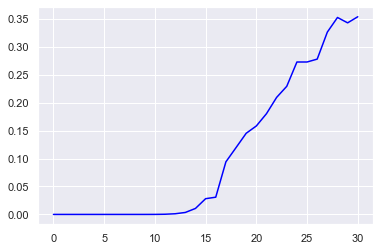

In [7]:
plt.plot(i_beta_21_04, color='blue')

In [8]:
scio.savemat('./i_beta_21_04.mat', {'i_beta_21_04': i_beta_21_04})